In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy
from collections import defaultdict
import importlib
import pprint

from interval import interval

import screed

import alignplot
importlib.reload(alignplot)

from alignplot import StackedDotPlot

## another tara genome, this time with two contaminants

In [3]:
if 0:
    dotplot = StackedDotPlot('TARA_PSE_MAG_00132', ('GCA_001550135.1', 'GCA_001641615.1'),
                             'list.csv', './genomes', use_mashmap=True)

In [4]:
if 0:
    dotplot = StackedDotPlot('TARA_ANW_MAG_00083', ('GCA_002171995.1',),
                             'list.csv', './genomes', use_mashmap=True)

In [5]:
if 0:
    dotplot = StackedDotPlot('GCA_001550135.1', ('TARA_PSE_MAG_00132', 'GCA_001641615.1'),
                             'list.csv', './genomes', use_mashmap=True)

In [6]:
if 0:
    dotplot2 = StackedDotPlot('GCA_003220225.1',
                             ['GCA_003222275.1',],
                             'list.csv', './genomes', use_mashmap=True)
    
if 1:
    dotplot = StackedDotPlot('GCA_003222275.1',
                             ['GCA_003220225.1'],
                             'list.csv', './genomes', use_mashmap=True)

['./genomes/GCA_003222275.1_ASM322227v1_genomic.fna']
found queryfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
found targetfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna


In [7]:
if 0:
    dotplot = StackedDotPlot('GCA_003222275.1',
                         ['GCA_003222275.1',],
                         'list.csv', './genomes', use_mashmap=False)

## Stacked DotPlot view

(this is an n-ary dotplot)

running mashmap...
running mashmap -q ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna -r ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna -o /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpapv7mt71/mashmap.out --pi 95
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpapv7mt71/mashmap.out.
shared w/Candidatus Rokubacteria bacterium: 435.6kb


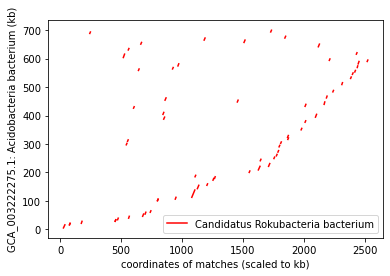

In [8]:
_ = dotplot()

## region response curve

underlying logic:

* for our primary use case here (contamination/legitimate "shared" nucleotides), we can consider nt alignments of >= 95% to be contamination to be removed
* we want to remove as many bp of contamination as possible with as little "legit" non-shared nt as possible.
* what's the response curve for that, and can we use it to figure out which genome(s) have the likely contaminants?

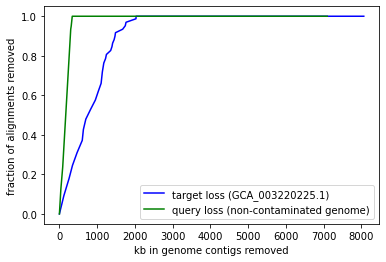

In [9]:
t_acc = dotplot.t_acc_list[0]
x, y, sat1 = dotplot.target_response_curve(t_acc)

x3, y3, sat3 = dotplot.query_response_curve()

plt.plot(x, y / max(y), 'b-', label=f'target loss ({t_acc})')
plt.plot(x3, y3 / max(y3), 'g-', label='query loss (non-contaminated genome)')

plt.xlabel('kb in genome contigs removed')
plt.ylabel('fraction of alignments removed')
plt.legend(loc='lower right')
plt.savefig('/tmp/acido-target.png')
#print(sat1, sat2)

## Reporting alignments

In [17]:
regions = []
for k, v in dotplot.results.items():
    regions.extend(v)

queryfile = dotplot.queryfile

# calculate and sort region summed kb in alignments over 95%            
regions_by_query = alignplot.group_regions_by(regions, "query")
regions_aligned_kb = alignplot.calc_regions_aligned_bp(
    regions_by_query, "query", filter_by=lambda r: r.pident >= 95
)
region_items = list(regions_aligned_kb.items())
region_items.sort(key=lambda x: -x[1])
top_name, top_aligned_kb = region_items[0]
top_name

'QHVJ01000158.1'

In [28]:
for name, aligned_kb in region_items[:5]:
    for alignment in regions_by_query[name]:
        a = alignment
        print(f"{a.query}[{int(a.qstart*1000)}:{int(a.qend*1000)}] aligns to {a.target}[{int(a.tstart*1000)}:{int(a.tend*1000)}] at {a.pident}% identity - {a.qend - a.qstart:.0f} kb")

QHVJ01000158.1[0:25538] aligns to QHRU01000033.1[105864:130699] at 99.3803% identity - 26 kb
QHVJ01000235.1[0:12577] aligns to QHRU01000060.1[47758:61041] at 99.7546% identity - 13 kb
QHVJ01000223.1[5000:16833] aligns to QHRU01000075.1[52944:62799] at 99.1113% identity - 12 kb
QHVJ01000160.1[5000:16637] aligns to QHRU01000055.1[13261:24601] at 96.5675% identity - 12 kb
QHVJ01000003.1[5000:15793] aligns to QHRU01000043.1[27103:38854] at 98.9885% identity - 11 kb
